# Implémentez un modèle de scoring

## Résumé

Le modèle avec les meilleurs résultats au niveau de l'objectif de priorisation de la détermination des clients susceptible de créer des pertes importantes est le Light GBM avec un seuil de 0.1.

Les meilleurs paramètres et les différents modèles ont été testé via une gridsearch CV. Le LGBM présente les meilleurs résultats et une absence d'overfitting avec comme paramètres {'classifier__boosting_type': 'gbdt', 'classifier__learning_rate': 0.04, 'classifier__max_depth': 10, 'classifier__n_estimators': 400}.

L'ensemble du travail de tracking a été réalisé sur MLFLOW via la plateforme Dagshub dans le but de permettre un travail à la fois en local, mais également sur des supports en ligne tel que Google colab.

## Analyse exploratoire

### Import des librairies indispensable à l'execution

Objectif: importer l'ensemble des ressources nécéssaire à l'execution du code.

In [1]:
import mlflow
import os
from getpass import getpass
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from evidently.test_suite import TestSuite
from evidently.test_preset import DataDriftTestPreset
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import seaborn as sns
import warnings
import shap
from mlflow.models import infer_signature
warnings.filterwarnings('ignore')

C:\Users\natha\anaconda3\envs\p_7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Création d'un environnement mlflow

Objectif: créer un environnement ml flow avec un tracking en ligne via la plateforme dagshub.

In [2]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'nathan.fardin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'eb8ac376caca4fd472bda902cd7bb8dbbad0abe2'
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'my-first-repo'

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

2025/01/06 07:16:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run MLflow on Colab at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/90e8c901e11940fbb97b1633641fbe22.
2025/01/06 07:16:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### Import des données

Objectif: créer des dataframes à partir des fichiers CSV fournis.

In [3]:
columns_description_HC = pd.read_csv("E:/OpenClassroom/p_7/HomeCredit_columns_description.csv",encoding='ISO-8859-1')
columns_description_HC.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


Nature : fichier contenant des informations sur les colonnes des autres csv.

In [4]:
bureau =pd.read_csv("E:/OpenClassroom/p_7/bureau.csv",encoding='ISO-8859-1')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Nature : Tout les précédents crédits du clients dans d'autres institution. Une ligne par crédit

In [5]:
bureau_balance = pd.read_csv("E:/OpenClassroom/p_7/bureau_balance.csv",encoding='ISO-8859-1')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Nature: solde mensuel des crédits dans bureau. Une ligne pour chaque mois de l'historique de chaque crédit.

In [6]:
credit_card_balance = pd.read_csv("E:/OpenClassroom/p_7/credit_card_balance.csv",encoding='ISO-8859-1')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Nature : apercu mensuel des soldes de crédits. Une ligne par mois pour chaque solde.

In [7]:
application_test =pd.read_csv("E:/OpenClassroom/p_7/application_test.csv",encoding='ISO-8859-1')
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Nature : Partie test des données de pret.(sans cible)

In [8]:
application_train = pd.read_csv("E:/OpenClassroom/p_7/application_train.csv",encoding='ISO-8859-1')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Nature : Partie train des données de pret.(avec cible)

In [9]:
previous_application =  pd.read_csv("E:/OpenClassroom/p_7/previous_application.csv",encoding='ISO-8859-1')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Nature: demande antérieur de pret au logement. Une ligne par demande.

In [10]:
pos_cash_balance = pd.read_csv("E:/OpenClassroom/p_7/POS_CASH_balance.csv",encoding='ISO-8859-1')
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Nature : apercu mensuel des pret point de vente et comptant par client.Une ligne pour chaque mois de chaque crédit.

In [11]:
installments_payments = pd.read_csv("E:/OpenClassroom/p_7/installments_payments.csv",encoding='ISO-8859-1')
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Nature: Historique des remboursements des crédits. Une ligne par paiement fait ou manqué.

## Analyse des données

### Répartition de la cible

Objectif : visualiser la répartition de la "TARGET" entre les clients ayant des retards de payement(1) et les autres cas (0).

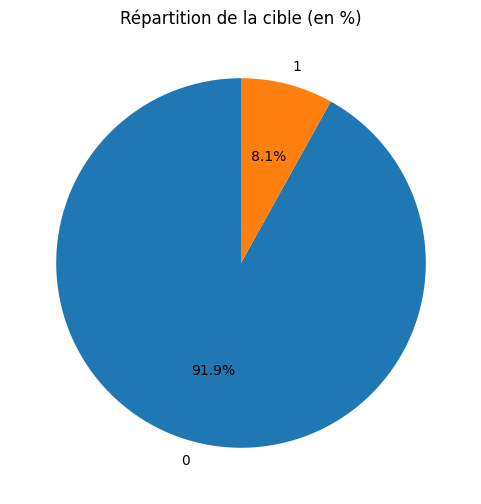

In [12]:
#Répartition des valeurs de la cible
target_count = application_train['TARGET'].value_counts()
target_percentage =target_count / target_count.sum() * 100

plt.figure(figsize=(6, 6))
plt.pie(target_percentage, labels=target_percentage.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition de la cible (en %)")
plt.show()

### Répartition par genre

Objectif : visualiser la répartition des clients par genre

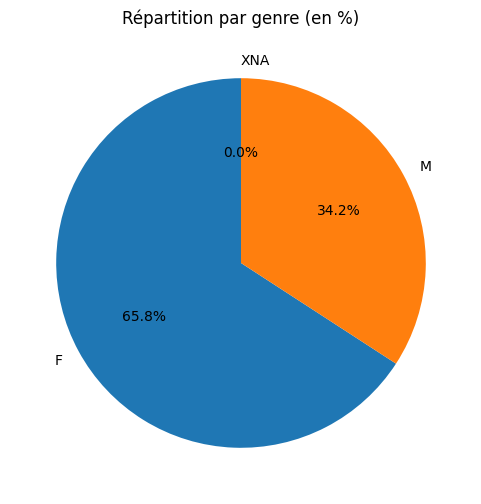

In [13]:
#Répartition par genre
gender_count = application_train['CODE_GENDER'].value_counts()
gender_percentage =gender_count / gender_count.sum() * 100

plt.figure(figsize=(6, 6))
plt.pie(gender_percentage, labels=gender_percentage.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition par genre (en %)")
plt.show()

### Répartition par niveau d'étude

Objectif : visualiser les clients par niveau d'étude atteint.

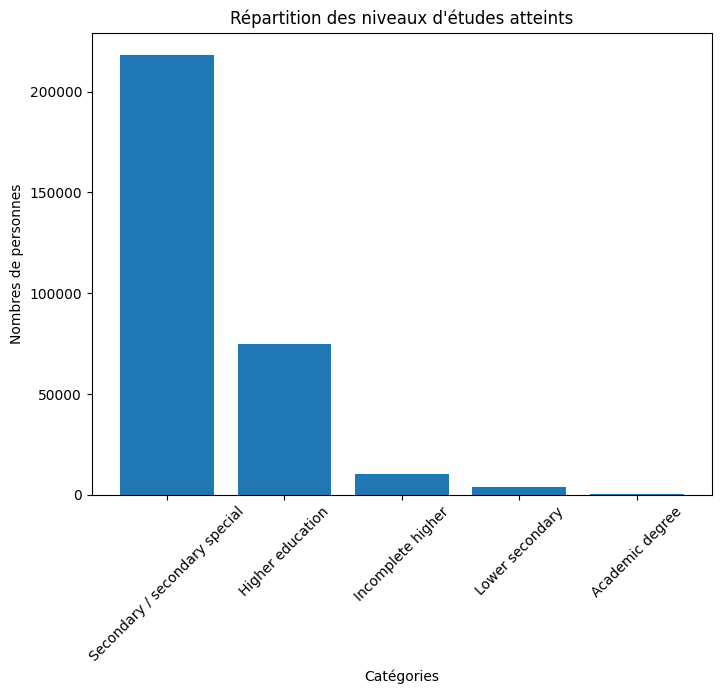

In [14]:
# Compte des occurrences
counts_education_type = application_train['NAME_EDUCATION_TYPE'].value_counts()

# Graphique en barres
plt.figure(figsize=(8, 6))
plt.bar(counts_education_type.index, counts_education_type.values)
plt.xlabel("Catégories")
plt.xticks(rotation=45)
plt.ylabel("Nombres de personnes")
plt.title("Répartition des niveaux d'études atteints")
plt.show()

## Utilisation du kernel Kaggle pour l'analyse exploratoire

Objectif : s'appuyer sur le kernel kaggle suivant : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook pour la suite de l'analyse exploratoire afin de gagner du temps.

### Valeurs manquantes

Objectif : verifier les valeurs manquantes dans chaque colonnes du dataframe "application_train".

In [15]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [16]:
# Missing values statistics
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


### Vérification des types de colonnes

Objectif : vérifier les types de chaque colonne du dataframe.

In [17]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

##" Vérification des classes pour les colonnes "objects"

Objectif : vérifier les différentes classes contenues dans les colonnes objets.

In [18]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Label encoder

Objectif créer un label encoder pour les colonnes objets avec 2 classes ou moins.

In [19]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### One-hot encoder pour les colonnes catégoriels

Objectif: rendre exploitable  pour un modèle de ML les differentes données catégoriels.

In [20]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Alignement des df

Objectif : s'assurer que les dataframe train et test aient le même nombre de colonne.

In [21]:
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### Age des clients

Objectif : determiner l'age des clients.

In [22]:
print(application_train['DAYS_BIRTH'].head())
(application_train['DAYS_BIRTH'] / -365).describe()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Jours employés des clients

Objectif: avoir un aperçu du nombre de jours de travail effectué par le client.

In [23]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Anomalie jours employés

Objectif : reperer des eventuelles anomalies dans le nombre de jours employés du client.

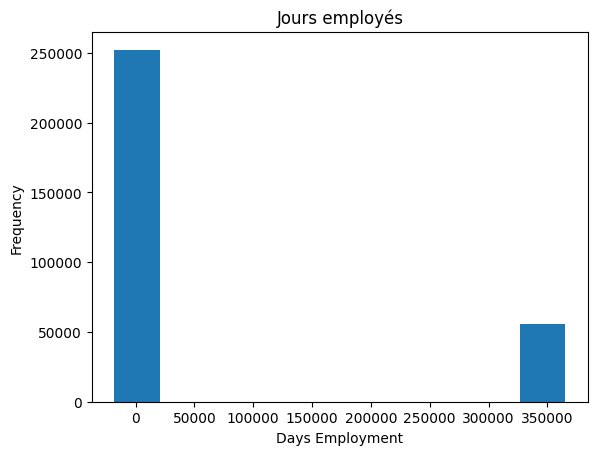

In [24]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Jours employés');
plt.xlabel('Days Employment');

In [25]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('Les prêts sans anomalie représentent : %0.2f%% des données' % (100 * non_anom['TARGET'].mean()))
print('Les anomalies sont en défaut de paiement dans : %0.2f%% des cas' % (100 * anom['TARGET'].mean()))
print('Il y a : %d jours de travail anormaux' % len(anom))

Les prêts sans anomalie représentent : 8.66% des données
Les anomalies sont en défaut de paiement dans : 5.40% des cas
Il y a : 55374 jours de travail anormaux


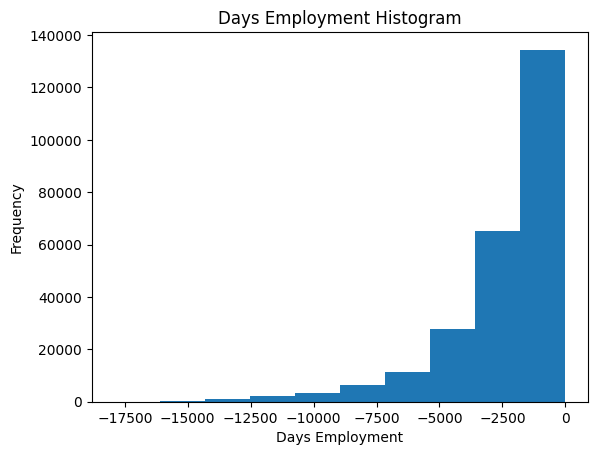

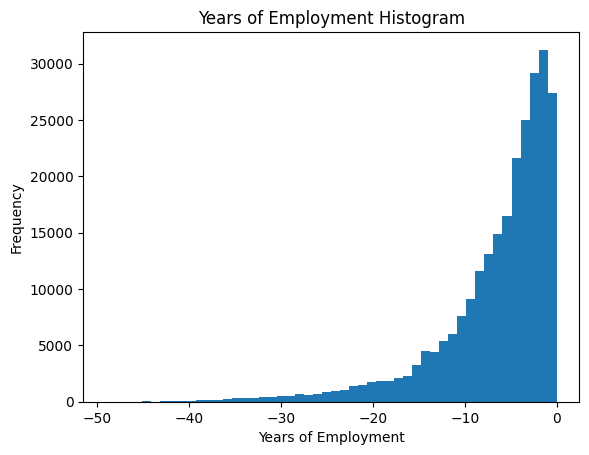

In [26]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()
# Conversion des jours en année
days_employed_in_years = application_train['DAYS_EMPLOYED'] / 365
# Création de l'histogramme du nombre d'années employé
days_employed_in_years.plot.hist(title='Years of Employment Histogram', bins=50)
plt.xlabel('Years of Employment')
plt.show()

In [27]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 9274 anomalies in the test data out of 48744 entries


## Correlations

Objectif : verifier les correlations entre les features et la cible.

In [28]:
# Find correlations with the target and sort
correlations = application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [29]:
# Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

np.float64(-0.07823930830982709)

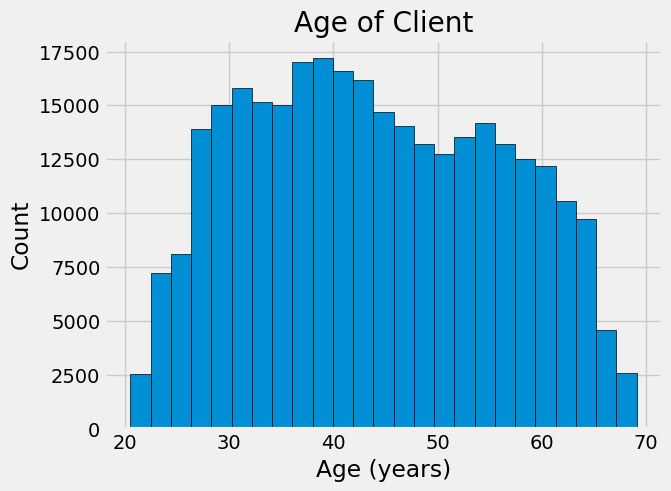

In [30]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

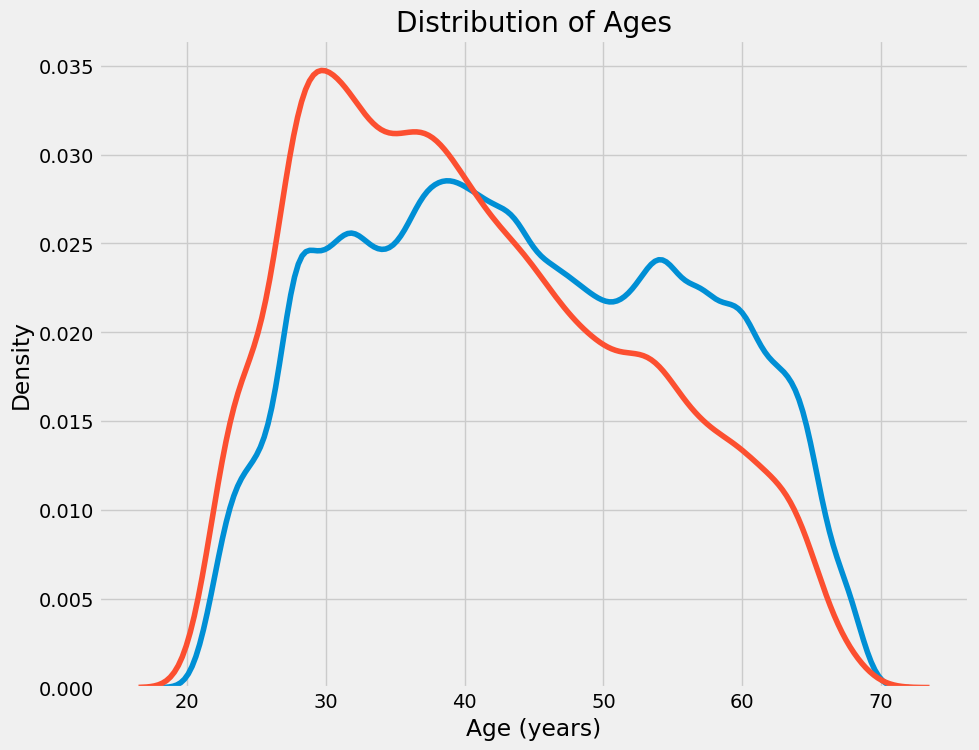

In [31]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [32]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [33]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


### Echec de remboursement et groupe d'age

Objectif : visualiser la capacité à rembourser le pret selon le groupe d'age ( par tranche de 5 ans) du client.

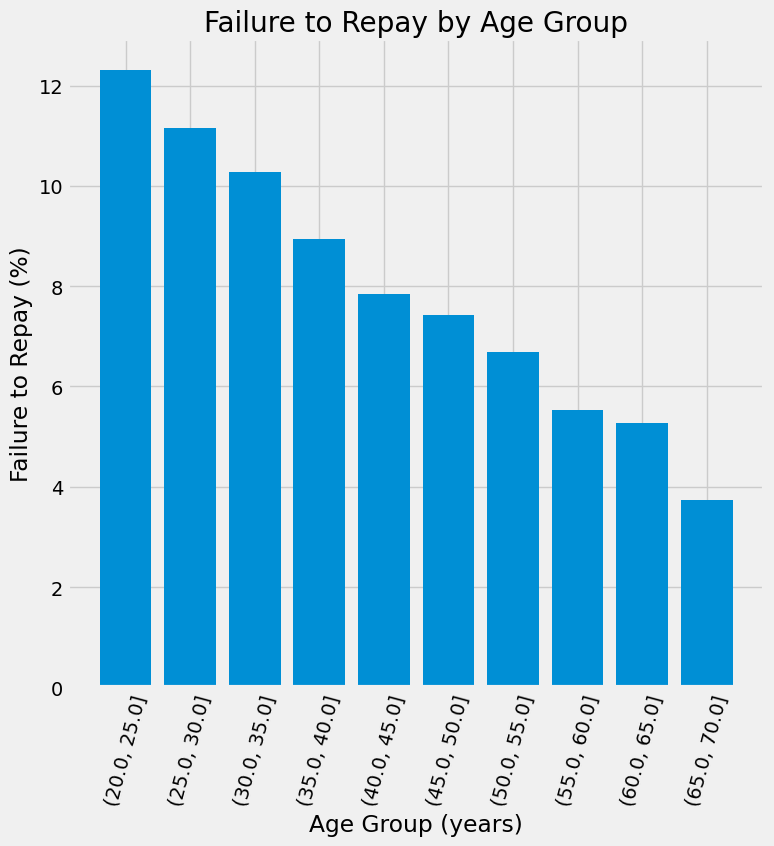

In [34]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

# Corrélation entre les sources exterieurs, la date de naissance et la cible.

Objectif: visualiser la corrélation entre la cible et ces différentes colonnes.

In [35]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


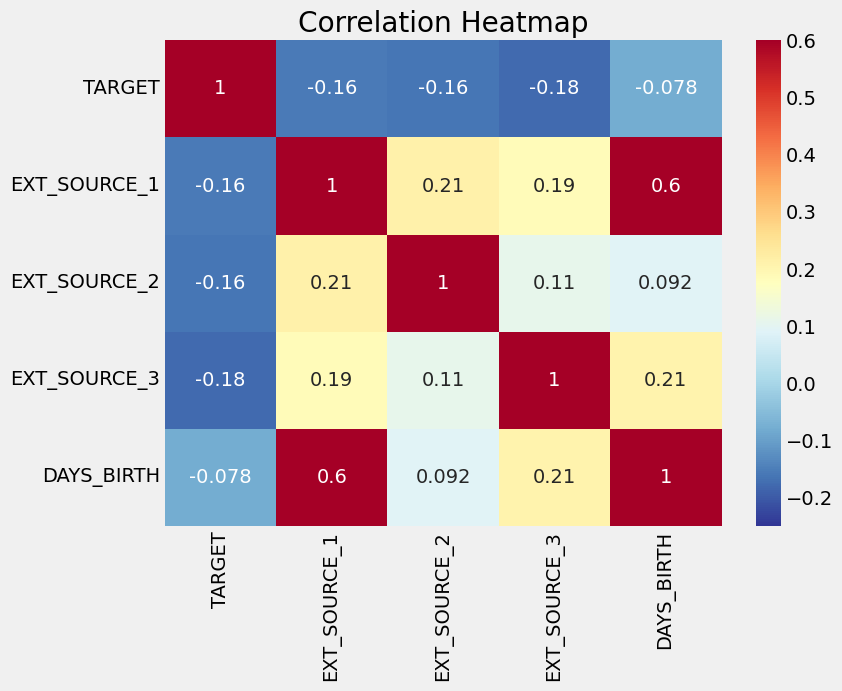

In [36]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

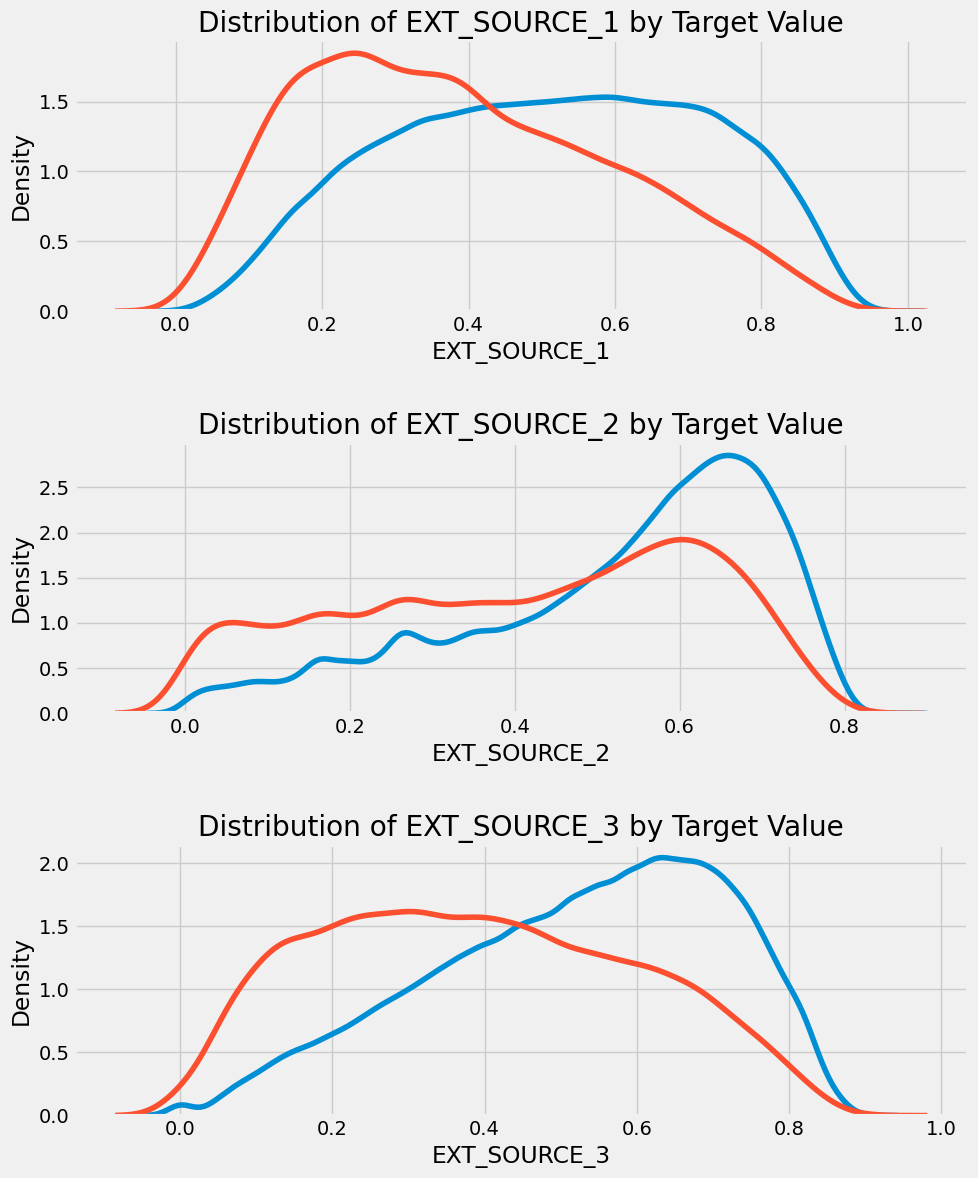

In [37]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


## Feature engineering

Objectif : créer/modifier des features à l'aide du kernel suivant : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

Objectif: créer un dataframe unique contenant l'ensemble des données clé répartis sur l'ensemble des données disponibles dans les différentes data base.

In [38]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### timer

Objectif : créer une fonction permettant d'indiquer le temps d'exécution des différentes étapes

In [39]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

### Fonctions clés

Objectif: créer un encodage one-hot pour les colonnes catégorielles

In [40]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

Objectif : lier, traiter et transformer les données des fichiers train et test.

In [41]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv("E:/OpenClassroom/p_7/application_train.csv",encoding='ISO-8859-1', nrows= num_rows)
    test_df = pd.read_csv("E:/OpenClassroom/p_7/application_test.csv",encoding='ISO-8859-1', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

Objectif : lier, traiter et transformer les données des fichiers bureau et bureau_balance.

In [42]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv("E:/OpenClassroom/p_7/bureau.csv",encoding='ISO-8859-1', nrows= num_rows)
    bb = pd.read_csv("E:/OpenClassroom/p_7/bureau_balance.csv",encoding='ISO-8859-1', nrows= num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

Objectif : traitement et transformation des données de previous_application.

In [43]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv("E:/OpenClassroom/p_7/previous_application.csv",encoding='ISO-8859-1', nrows= num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

Objectif : transformer et traiter les données de POS_CASH_balance

In [44]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv("E:/OpenClassroom/p_7/POS_CASH_balance.csv",encoding='ISO-8859-1', nrows= num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

Objectif : transformer et traiter le fichier installments_payments

In [45]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv("E:/OpenClassroom/p_7/installments_payments.csv",encoding='ISO-8859-1', nrows= num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

Objectif : traiter et transformer credit_card_balance

In [46]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("E:/OpenClassroom/p_7/credit_card_balance.csv",encoding='ISO-8859-1', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

Objectif : créer une fonction permettant d'appliquer l'ensemble des précédentes fonctions créé. Création des différentes jointures pour obtenir un dataframe unique contenant l'ensemble des features.

In [47]:
def main(debug=False):
    num_rows = 150000 if debug else None
    df_feature_engineering = application_train_test(num_rows)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df_feature_engineering = df_feature_engineering.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df_feature_engineering = df_feature_engineering.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df_feature_engineering = df_feature_engineering.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df_feature_engineering = df_feature_engineering.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df_feature_engineering = df_feature_engineering.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    return df_feature_engineering

Objectif : lancer l'ensemble des opérations sur les differents fichiers.

In [48]:
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_feature_engineering = main(debug=True)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        full_df_for_best_model = main(debug=False)

Train samples: 150000, test samples: 48744
Bureau df shape: (34117, 113)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (110071, 247)
Process previous_applications - done in 2s
Pos-cash balance df shape: (104063, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (58741, 26)
Process installments payments - done in 1s
Credit card balance df shape: (64370, 131)
Process credit card balance - done in 1s
Full model run - done in 8s
Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 12s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s
Full model run - done in 61s


## Machine learning

### Fonctions

Objectif : fonction permettant de réaliser la gridsearch logguer à mlflow pour les différents modèles.

In [49]:
#creation du dataframe de base pour recevoir les resultats
base_ml_df = pd.DataFrame(columns=['model', 'train_mean', 'test_mean', 'seuil_metier', 'accuracy', 'auc', 'score_metier','time'])

def grid_search_ml(grid_search, model):
    global base_ml_df

    # Mesure du temps
    start_time = time.time()

    # Entrainement du modèle
    model_ml = model
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Prédictions
    y_pred = best_model.predict(X_test)
    signature = infer_signature(X_test, y_pred)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Récupération des scores moyens pour chaque métrique
    mean_train_scores = grid_search.cv_results_['mean_train_score_fn_fp']
    mean_test_scores = grid_search.cv_results_['mean_test_score_fn_fp']

    # Calcul des métriques
    roc_auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Calcul du score métier
    score_fn_fp = score_metier(y_test, y_proba)

    # Récupération du seuil métier du meilleur modèle
    seuils_metiers_pour_tous_les_modeles = grid_search.cv_results_['mean_test_Seuil metier']
    seuil_metier_best_model = seuils_metiers_pour_tous_les_modeles[grid_search.best_index_]

    # Fin de la mesure
    end_time = time.time()
    execution_time = end_time - start_time

    # Logguer les métriques
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("train_mean_score_fn_fp", -np.mean(mean_train_scores))
    mlflow.log_metric("test_mean_score_fn_fp", -np.mean(mean_test_scores))
    mlflow.log_metric("precision", report['weighted avg']['precision'])
    mlflow.log_metric("recall", report['weighted avg']['recall'])
    mlflow.log_metric("f1_score", report['weighted avg']['f1-score'])
    mlflow.log_metric("score_fn_fp", score_fn_fp)
    mlflow.log_metric("Treshold", seuil_metier_best_model)

    # Logguer les hyperparamètres du modèle
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler", "MinMaxScaler")
    mlflow.log_param("oversampling", "SMOTE")
    mlflow.log_param("classifier", model_ml)
    mlflow.log_param("best_params", grid_search.best_params_)

    # Logguer le modèle
    mlflow.sklearn.log_model(
        best_model,
        artifact_path=f"model{model}",
        signature=signature,
        registered_model_name=f"model_{model}",
    )
    # Ajout de tags pour identifier la run
    mlflow.set_tag("pipeline_stage", "production_ready")
    mlflow.set_tag("algorithm", model_ml)

    # Création du DataFrame pour l'exécution
    new_result = pd.DataFrame({
        'model': [str(model_ml)],
        'train_mean': [-np.mean(mean_train_scores)],
        'test_mean': [-np.mean(mean_test_scores)],
        'seuil_metier': [seuil_metier_best_model],
        'accuracy': [accuracy],
        'auc': [roc_auc],
        'score_metier' :[score_fn_fp],
        'time': [execution_time]
    })

    # Fusion avec le DataFrame global existant
    base_ml_df = pd.concat([base_ml_df, new_result], ignore_index=True)

    # Output
    print("ROC AUC Score:", roc_auc)
    print("Accuracy:", accuracy)
    print("Custom Score (FN/FP):", score_fn_fp)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return base_ml_df

Objectif : définir la fonction permettant de calculer le score metier le plus bas et le score correspondant.

In [50]:
#Recherche du meilleur seuil et du score le plus bas
def find_best_threshold(y, y_pred_prob):

    scores = np.array([])

    for threshold in np.arange(0, 0.6, 0.1):

        y_pred = y_pred_prob > threshold

        mat_conf = confusion_matrix(y, y_pred)

        tn = mat_conf[0, 0]
        fn = mat_conf[1, 0]
        fp = mat_conf[0, 1]
        tp = mat_conf[1, 1]

        score = 10*fn + 1*fp

        scores = np.append(scores, score)

    best_score = scores.min()
    best_threshold = np.arange(0, 0.6, 0.1)[scores.argmin()]

    return best_score, best_threshold


def score_metier(y, y_pred_prob):
    best_score, best_threshold = find_best_threshold(y, y_pred_prob)
    return best_score

def seuil_metier(y, y_pred_prob):
    best_score, best_threshold = find_best_threshold(y, y_pred_prob)
    return best_threshold

Objectif : fonction permettant de reperer les colonnes avec des valeurs infinies

In [51]:
# Identifier les colonnes contenant des valeurs inf ou -inf
def check_infinite_values(X):
    # Sélectionner uniquement les colonnes numériques
    numeric_columns = X.select_dtypes(include=[np.number])
    # Identifier les colonnes contenant des valeurs infinies
    infinite_columns = numeric_columns.columns[np.isinf(numeric_columns).any()].tolist()
    if infinite_columns:
        print("Colonnes contenant des valeurs infinies (inf ou -inf) :")
        for col in infinite_columns:
            print(f" - {col}")
    else:
        print("Aucune colonne ne contient de valeurs infinies.")
    return infinite_columns

Objectif : fonction permettant de nettoyer les colonnes avec des valeurs infinies

In [52]:
# Nettoyer les colonnes spécifiques
def clean_dataset(X, columns_to_clean):
    # Remplacer les valeurs inf et -inf par NaN uniquement dans les colonnes identifiées
    for col in columns_to_clean:
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)
        # Remplacer les NaN par la médiane de la colonne
        X[col].fillna(X[col].median(), inplace=True)
    return X

### Chargement des données

Objectifs : Charger le df et effectuer la séparation train/test.

In [53]:
# Chargement du df
df = df_feature_engineering.copy()
target_col =df['TARGET']
#suppression valeur NaN dans la cible
df = df.dropna(subset=['TARGET'])

# Séparation des caractéristiques et de la cible
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("séparation effectué train/test")

# Vérification des valeurs infinies
print("Vérification des valeurs infinies dans les données d'entraînement :")
infinite_columns_train = check_infinite_values(X_train)

print("\nVérification des valeurs infinies dans les données de test :")
infinite_columns_test = check_infinite_values(X_test)

# Nettoyage des colonnes problématiques uniquement
X_train = clean_dataset(X_train, infinite_columns_train)
X_test = clean_dataset(X_test, infinite_columns_test)

séparation effectué train/test
Vérification des valeurs infinies dans les données d'entraînement :
Colonnes contenant des valeurs infinies (inf ou -inf) :
 - INSTAL_PAYMENT_PERC_MAX
 - INSTAL_PAYMENT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_SUM

Vérification des valeurs infinies dans les données de test :
Aucune colonne ne contient de valeurs infinies.


### Création de la pipeline et logistic regression

Objectif : créer la pipeline d'execution du modèle et lancer une gridsearch pour un modèle de regression logistic

In [54]:
# Transformations pour les colonnes numériques
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Pré-processeur
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# Scoring
scoring = {
    'auc_score': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score),
    'score_fn_fp': make_scorer(score_metier, needs_proba=True, greater_is_better = False),
    "Seuil metier": make_scorer(seuil_metier, needs_proba=True, greater_is_better = False)
}

# Hyperparamètres
pram_grid_lr = {
    'classifier__max_iter': [600,300,900],#900
    'classifier__solver': ['lbfgs','liblinear']#'liblinear'
}

# Pipeline complet
model_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=model_lr,
    param_grid=pram_grid_lr,
    scoring=scoring,
    refit='score_fn_fp',
    cv=4,
    n_jobs=-1,
    return_train_score=True
)
print("début de la gridsearch pour la regression")
# Démarrage d'une nouvelle run MLflow
with mlflow.start_run(run_name="Pipeline_LogisticRegression_SMOTE"):
     grid_search_ml(lr_grid_search, "Logistic Regression")

début de la gridsearch pour la regression


  File "C:\Users\natha\anaconda3\envs\p_7\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\natha\anaconda3\envs\p_7\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\natha\anaconda3\envs\p_7\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\natha\anaconda3\envs\p_7\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
Registered model 'model_Logistic Regression' already exists. Creating a new version of this model...
2025/01/06 07:32:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_Logistic Regression, version 3
Created version '3' of model 'model_Logistic Regression'.


ROC AUC Score: 0.7339228159745449
Accuracy: 0.6952
Custom Score (FN/FP): 17091.0
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     27549
         1.0       0.16      0.64      0.26      2451

    accuracy                           0.70     30000
   macro avg       0.56      0.67      0.53     30000
weighted avg       0.89      0.70      0.76     30000



2025/01/06 07:32:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pipeline_LogisticRegression_SMOTE at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/4ff68a30f0174ea4a6719c9c7a222dc0.
2025/01/06 07:32:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### DummyClassifier

Objectif : réaliser un modèle qui servira de base de référence pour la comparaison.

In [55]:
# Pipeline avec DummyClassifier
dummy_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='stratified', random_state=42))
])

# Entraînement du DummyClassifier
dummy_pipeline.fit(X_train, y_train)

# Prédictions
y_dummy_pred = dummy_pipeline.predict(X_test)
y_dummy_proba = dummy_pipeline.predict_proba(X_test)[:, 1]

# Calcul des métriques
roc_auc_dummy = roc_auc_score(y_test, y_dummy_proba)
score_fn_fp_dummy = score_metier(y_test, y_dummy_proba)

# Rapport de classification
report_dummy = classification_report(y_test, y_dummy_pred)

# Affichage des résultats
print("Performance du DummyClassifier:")
print(f"ROC AUC: {roc_auc_dummy}")
print(f"Custom Score (FN/FP): {score_fn_fp_dummy}")
print("Classification Report:")
print(report_dummy)

# Logging des résultats dans MLflow
with mlflow.start_run(run_name="DummyClassifier_Baseline"):
    # Logguer les métriques
    mlflow.log_metric("roc_auc", roc_auc_dummy)
    mlflow.log_metric("score_fn_fp", score_fn_fp_dummy)

    # Logguer les paramètres
    mlflow.log_param("dummy_strategy", "most_frequent")
    mlflow.log_param("oversampling", "None")
    mlflow.log_param("classifier", "DummyClassifier")

    # Logguer les résultats du rapport de classification
    mlflow.log_text(report_dummy, "classification_report.txt")

    print("Résultats DummyClassifier loggués dans MLflow.")

Performance du DummyClassifier:
ROC AUC: 0.5009201808123529
Custom Score (FN/FP): 24711.0
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     27549
         1.0       0.08      0.08      0.08      2451

    accuracy                           0.85     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.85      0.85      0.85     30000



2025/01/06 07:32:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run DummyClassifier_Baseline at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/4f3dcc508fbc4b31b5060a80f53c4011.
2025/01/06 07:32:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


Résultats DummyClassifier loggués dans MLflow.


### Random forest

Objectif : réaliser une gridsearch pour déterminer les meilleures parametres pour la random forest

In [56]:
pram_grid_rf = {
    'classifier__max_depth': [10,8],
    'classifier__n_estimators': [150,250],
    'classifier__min_samples_leaf': [9,7],
    'classifier__max_features': ['sqrt']
}

#random forest
# Pipeline complet
model_RF = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_grid_search = GridSearchCV(estimator=model_RF,
                              param_grid=pram_grid_rf,
                              scoring=scoring,
                              refit='score_fn_fp',
                              cv= 3,
                              n_jobs=-1,
                              return_train_score=True)

# Démarrage d'une nouvelle run MLflow
with mlflow.start_run(run_name="Pipeline_RandomForest_SMOTE"):
     grid_search_ml(rf_grid_search,"RandomForestClassifier")

Registered model 'model_RandomForestClassifier' already exists. Creating a new version of this model...
2025/01/06 07:42:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_RandomForestClassifier, version 3
Created version '3' of model 'model_RandomForestClassifier'.


ROC AUC Score: 0.6293727674789296
Accuracy: 0.8348
Custom Score (FN/FP): 20404.0
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     27549
         1.0       0.15      0.22      0.18      2451

    accuracy                           0.83     30000
   macro avg       0.54      0.56      0.54     30000
weighted avg       0.86      0.83      0.85     30000



2025/01/06 07:43:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pipeline_RandomForest_SMOTE at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/7fb4c259ced4482bb18c8ccf190ef9f0.
2025/01/06 07:43:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### Light GBM

Objectif : réaliser une gridsearch pour un modèle light GBM

In [57]:
pram_grid_lgbm = {
    'classifier__max_depth': [6,8,10],
    'classifier__n_estimators': [400,300,500],
    'classifier__learning_rate': [0.08,0.02,0.04,0.06],
    'classifier__boosting_type' :['gbdt']
}

#lgbm
# Pipeline complet
model_lgbm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42))
])

lgbm_grid_search = GridSearchCV(estimator=model_lgbm,
                              param_grid=pram_grid_lgbm,
                              scoring=scoring,
                              refit='score_fn_fp',
                              cv= 3,
                              n_jobs=4,
                              return_train_score=True)

# Démarrage d'une nouvelle run MLflow
with mlflow.start_run(run_name="Pipeline_LightGBM_SMOTE"):
     grid_search_ml(lgbm_grid_search,"LGBMClassifier")

[LightGBM] [Info] Number of positive: 110195, number of negative: 110195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125066
[LightGBM] [Info] Number of data points in the train set: 220390, number of used features: 580
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Registered model 'model_LGBMClassifier' already exists. Creating a new version of this model...
2025/01/06 08:20:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_LGBMClassifier, version 3
Created version '3' of model 'model_LGBMClassifier'.


ROC AUC Score: 0.7445448449044445
Accuracy: 0.9178
Custom Score (FN/FP): 16541.0
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     27549
         1.0       0.45      0.03      0.05      2451

    accuracy                           0.92     30000
   macro avg       0.69      0.51      0.51     30000
weighted avg       0.88      0.92      0.88     30000



2025/01/06 08:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pipeline_LightGBM_SMOTE at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/33363e5372c54a2cb0d56e9fe49f7e1e.
2025/01/06 08:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### XGBOOST

Objectif : réaliser une gridsearch pour XGBOOST



In [58]:
pram_grid_xgboost = {
    'classifier__objective': ['binary:logistic'],
    'classifier__max_depth': [9,7],
    'classifier__n_estimators': [300,400],
    'classifier__learning_rate': [0.5,0.1],
    'classifier__subsample' :[0.8,1]
}

#lgbm
# Pipeline complet
model_xgboost = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

xg_grid_search = GridSearchCV(estimator=model_xgboost,
                              param_grid=pram_grid_xgboost,
                              scoring=scoring,
                              refit='score_fn_fp',
                              cv= 2,
                              n_jobs=4,
                              return_train_score=True)

# Démarrage d'une nouvelle run MLflow
with mlflow.start_run(run_name="Pipeline_xgboost_SMOTE"):
     grid_search_ml(xg_grid_search,"XGBClassifier")

Registered model 'model_XGBClassifier' already exists. Creating a new version of this model...
2025/01/06 08:32:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_XGBClassifier, version 3
Created version '3' of model 'model_XGBClassifier'.


ROC AUC Score: 0.7416470002880073
Accuracy: 0.9171
Custom Score (FN/FP): 16802.0
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     27549
         1.0       0.40      0.03      0.06      2451

    accuracy                           0.92     30000
   macro avg       0.66      0.51      0.51     30000
weighted avg       0.88      0.92      0.88     30000



2025/01/06 08:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pipeline_xgboost_SMOTE at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/4b848798876643a6a04df4e1155f72e4.
2025/01/06 08:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### Résultat des modèles

In [59]:
print(base_ml_df)

                    model    train_mean     test_mean  seuil_metier  accuracy  \
0     Logistic Regression  49184.541667  16863.375000          -0.5    0.6952   
1  RandomForestClassifier  52016.000000  27636.666667          -0.4    0.8348   
2          LGBMClassifier  31698.879630  22707.064815          -0.1    0.9178   
3           XGBClassifier   2478.781250  38733.468750          -0.1    0.9171   

        auc  score_metier         time  
0  0.733923       17091.0   804.066232  
1  0.629373       20404.0   601.537875  
2  0.744545       16541.0  2248.905256  
3  0.741647       16802.0   661.922256  


### Dataframe pour api

Objectif: créer un dataframe limité pour permettre la création d'une API sur python anywhere

In [60]:
# Séparation des deux classes
class_0 = full_df_for_best_model[full_df_for_best_model['TARGET'] == 0]
class_1 = full_df_for_best_model[full_df_for_best_model['TARGET'] == 1]
# Vérification des valeurs infinies
print("Vérification des valeurs infinies dans les données d'entraînement :")
infinite_columns_0 = check_infinite_values(class_0)
print("\nVérification des valeurs infinies dans les données de test :")
infinite_columns_1 = check_infinite_values(class_1)
# Nettoyage des colonnes problématiques
class_0 = clean_dataset(class_0, infinite_columns_0)
class_1 = clean_dataset(class_1, infinite_columns_1)

min_class_count = min(len(class_0), len(class_1))
max_samples_per_class = 1000 // 2

sampled_class_0 = class_0.sample(n=min(max_samples_per_class, min_class_count), random_state=42)
sampled_class_1 = class_1.sample(n=min(max_samples_per_class, min_class_count), random_state=42)

balanced_data = pd.concat([sampled_class_0, sampled_class_1]).sample(frac=1, random_state=42)

# Suppression de TARGET
balanced_data_without_target = balanced_data.drop(columns=['TARGET'])
# Export du DataFrame
balanced_data_without_target.to_csv("E:/OpenClassroom/p_7/api_test_pe.csv", index=False)

Vérification des valeurs infinies dans les données d'entraînement :
Colonnes contenant des valeurs infinies (inf ou -inf) :
 - PREV_APP_CREDIT_PERC_MAX
 - PREV_APP_CREDIT_PERC_MEAN
 - REFUSED_APP_CREDIT_PERC_MAX
 - REFUSED_APP_CREDIT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_MAX
 - INSTAL_PAYMENT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_SUM

Vérification des valeurs infinies dans les données de test :
Colonnes contenant des valeurs infinies (inf ou -inf) :
 - INSTAL_PAYMENT_PERC_MAX
 - INSTAL_PAYMENT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_SUM


### Meilleur modèle

Objectif : entrainer et utiliser le meilleur modèle sur l'ensemble des données

In [61]:
full_df_for_best_model = full_df_for_best_model.dropna(subset=['TARGET'])


# Séparation des données en train et test
X = full_df_for_best_model.drop(columns=['TARGET'])  # Remplacez 'target' par le nom réel de la colonne cible
y = full_df_for_best_model['TARGET']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des valeurs infinies
print("Vérification des valeurs infinies dans les données d'entraînement :")
infinite_columns_train = check_infinite_values(X_train)

print("\nVérification des valeurs infinies dans les données de test :")
infinite_columns_test = check_infinite_values(X_test)

# Nettoyage des colonnes problématiques uniquement
X_train = clean_dataset(X_train, infinite_columns_train)
X_test = clean_dataset(X_test, infinite_columns_test)


# Pipeline complet
model_lgbm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(boosting_type='gbdt', learning_rate=0.04, max_depth=10, n_estimators=400, random_state=42))
])

with mlflow.start_run(run_name="Pipeline_LGBM_best_model"):
    # Entraînement du modèle
    model_lgbm.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred_prob = model_lgbm.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive

    # Application du meilleur seuil
    optimal_threshold = 0.1
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)

    # Calcul des métriques
    auc = roc_auc_score(y_test, y_pred_prob)
    auc =float(auc)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = float(accuracy)

    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Calcul du score personnalisé
    best_score = score_metier(y_test, y_pred_prob)
    best_score = int(best_score)
    best_threshold = seuil_metier(y_test, y_pred_prob)
    best_threshold =float(best_threshold)

    print(f"Best Score (custom metric): {best_score}")
    print(f"Best Threshold (custom metric): {best_threshold}")


    # Enregistrement des métriques
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Best Score", best_score)
    mlflow.log_metric("Best Threshold", best_threshold)

    # Enregistrement des paramètres du modèle
    model_params = model_lgbm.named_steps['classifier'].get_params()
    mlflow.log_params(model_params)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model_lgbm, "model")

Vérification des valeurs infinies dans les données d'entraînement :
Colonnes contenant des valeurs infinies (inf ou -inf) :
 - PREV_APP_CREDIT_PERC_MAX
 - PREV_APP_CREDIT_PERC_MEAN
 - REFUSED_APP_CREDIT_PERC_MAX
 - REFUSED_APP_CREDIT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_MAX
 - INSTAL_PAYMENT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_SUM

Vérification des valeurs infinies dans les données de test :
Colonnes contenant des valeurs infinies (inf ou -inf) :
 - INSTAL_PAYMENT_PERC_MAX
 - INSTAL_PAYMENT_PERC_MEAN
 - INSTAL_PAYMENT_PERC_SUM
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.219666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142600
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 601
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC: 0.7730
Accuracy: 0.7422


2025/01/06 08:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/06 08:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pipeline_LGBM_best_model at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0/runs/969151c81e9348f9845a12faa18c3c60.
2025/01/06 08:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/nathan.fardin/my-first-repo.mlflow/#/experiments/0.


### Sauvegarde du modèle

Obejctif: sauvegarder le modèle entrainé afin de le réutiliser pour l'appel api.

In [62]:
# Sauvegarde du modèle
with open('E:/OpenClassroom/p_7/model.pkl', 'wb') as file:
    pickle.dump(model_lgbm, file)

### Analyse SHAP

Objectif : obtenir un graphique des features importances au niveau global et local.

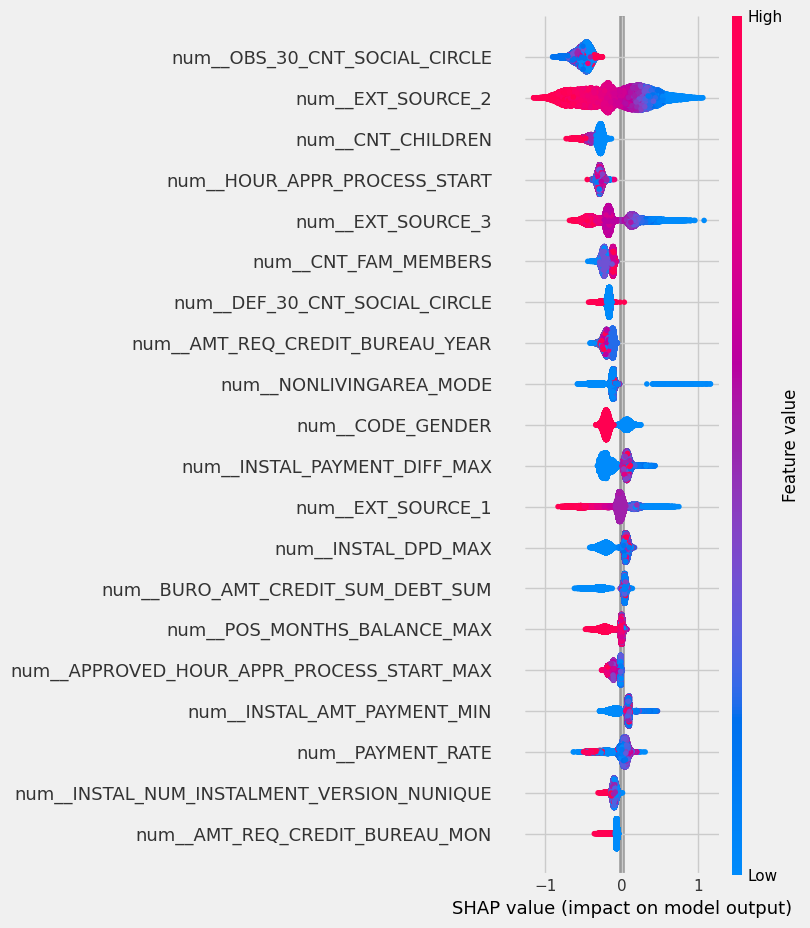

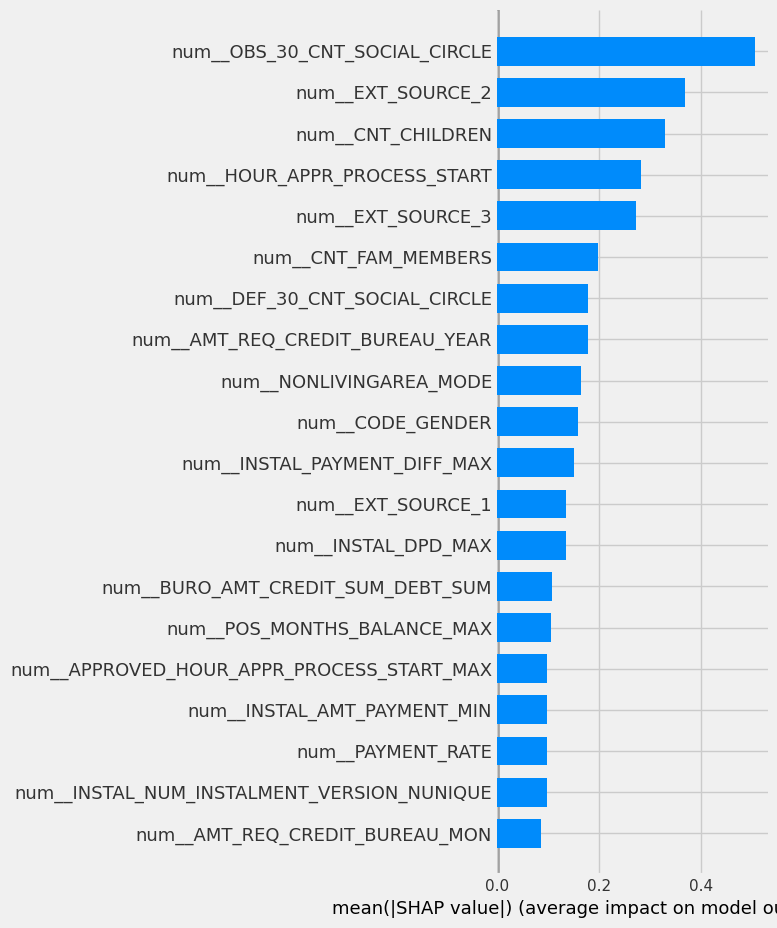

In [65]:
# Extraction du classifieur final du pipeline
classifier = model_lgbm.named_steps['classifier']

# Préprocesseur données de test
X_test_processed = model_lgbm.named_steps['preprocessor'].transform(X_test)
transformed_columns = model_lgbm.named_steps['preprocessor'].get_feature_names_out(input_features=X_test.columns)

#TreeExplainer pour LightGBM
explainer = shap.TreeExplainer(classifier)

# Calcul des valeurs SHAP
shap_values = explainer.shap_values(X_test_processed, check_additivity=False)

# Converssion de X_test_processed en DataFrame avec les noms de colonnes d'origine
X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=transformed_columns,
    index=X_test.index
)

# Résumé SHAP avec les noms des colonnes
shap.summary_plot(shap_values, features=X_test_processed_df, feature_names=X_test_processed_df.columns)
shap.summary_plot(shap_values, features=X_test_processed_df, feature_names=X_test_processed_df.columns, plot_type='bar')

# Analyse SHAP pour un client choisi au hasard
random_index = np.random.choice(X_test.index)
random_sample = X_test_processed_df.loc[random_index:random_index]

# Calcul des valeurs SHAP pour cette cible
shap_values_random = explainer.shap_values(random_sample, check_additivity=False)

# graphique
shap.force_plot(
    explainer.expected_value,
    shap_values_random[0],
    random_sample.values[0],
    feature_names=transformed_columns
)

#export du graphique (affichage spyder impossible)
shap.save_html("E:/OpenClassroom/p_7/local_shap_explanation.html", shap.force_plot(
    explainer.expected_value,
    shap_values_random[0],
    random_sample.values[0],
    feature_names=transformed_columns
))

### DataDrift

Objectif: vérifier l'absence de datadrift

In [64]:
# Simulation de deux périodes distinctes
reference_data = X_train
current_data = X_test
# Vérification du data drift
data_drift_suite = TestSuite(tests=[
    DataDriftTestPreset()
])
data_drift_suite.run(reference_data=reference_data, current_data=current_data)
data_drift_suite.show()

#export des resultats
data_drift_suite.save_html("E:/OpenClassroom/p_7/data_drift_report.html")